In [1]:
import pandas as pd
import os

def load_datasets(base_path='e:\\SEMESTER 5\\DEEP LEARNING\\FINAL\\neurips-open-polymer-prediction-2025'):
    """
    Load all datasets from the project directory.
    
    Parameters:
    -----------
    base_path : str
        Base path to the project directory
        
    Returns:
    --------
    dict : Dictionary containing all loaded datasets
    """
    datasets = {}
    
    # Load main train dataset
    train_path = os.path.join(base_path, 'train.csv')
    datasets['train'] = pd.read_csv(train_path)
    # Load main test dataset
    test_path = os.path.join(base_path, 'test.csv')
    datasets['test'] = pd.read_csv(test_path)
    
    # Load supplementary datasets
    supplement_path = os.path.join(base_path, 'train_supplement')
    for i in range(1, 5):
        dataset_path = os.path.join(supplement_path, f'dataset{i}.csv')
        datasets[f'dataset{i}'] = pd.read_csv(dataset_path)
    
    return datasets


data = load_datasets()
test_df = data['test']
train_df = data['train']
dataset1_df = data['dataset1']
dataset2_df = data['dataset2']
dataset3_df = data['dataset3']
dataset4_df = data['dataset4']

In [2]:
from rdkit import Chem 
from rdkit.Chem import AllChem 
from rdkit.Chem.rdmolops import RemoveHs

def safe_mol_from_smiles(smiles):
    if pd.isna(smiles) or not isinstance(smiles, str) or smiles.strip() == '':
        return None
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol
    except:
        return None
    
def largest_fragment(mol):
    frags = Chem.GetMolFrags(mol, asMols=True)
    if len(frags) == 1:
        return mol
    largest = max(frags, key=lambda m: m.GetNumAtoms())
    return largest

def neutralize_molecule(mol):
    try:
        # RDKit built-in neutralization
        uncharger = Chem.rdMolStandardize.Uncharger()
        mol = uncharger.uncharge(mol)
        return mol
    except:
        return mol
    
def canonicalize(mol):
    try:
        return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None
    
    
def sanitize_smiles_pipeline(smiles):
    # Step 1: Safe Mol
    mol = safe_mol_from_smiles(smiles)
    if mol is None:
        return None

    # Step 2: Remove salts
    mol = largest_fragment(mol)

    # Step 3: Neutralize
    mol = neutralize_molecule(mol)

    # Step 4: Re-sanitize
    try:
        Chem.SanitizeMol(mol)
    except:
        return None

    # Step 5: Canonicalize
    return canonicalize(mol)

In [3]:
# Replace your validate_smiles_entries call with this:

def validate_smiles_entries_dict(dfs_dict, smiles_column="SMILES"):
    """
    SMILES validation using explicit dictionary keys.
    """
    results = {}

    for df_name, df in dfs_dict.items():
        df_copy = df.copy()

        canonical_list = []
        errors = []

        for s in df_copy[smiles_column]:
            try:
                mol = Chem.MolFromSmiles(s, sanitize=True)
                if mol is None:
                    canonical_list.append(None)
                    errors.append({"SMILES": s, "error": "MolFromSmiles returned None"})
                else:
                    canon = Chem.MolToSmiles(mol, canonical=True)
                    canonical_list.append(canon)
                    errors.append(None)
            except Exception as e:
                canonical_list.append(None)
                errors.append({"SMILES": s, "error": str(e)})

        df_copy["canonical_SMILES"] = canonical_list
        df_copy["sanitization_error"] = errors

        # Summary QC
        total = len(df_copy)
        valid = df_copy["canonical_SMILES"].notna().sum()
        invalid = total - valid
        unique_raw = df_copy[smiles_column].nunique()
        unique_canon = df_copy["canonical_SMILES"].nunique()

        print("\n=====================================")
        print(f"🔎 QC for {df_name}")
        print("=====================================")
        print(f"Total entries:                  {total}")
        print(f"Valid sanitized molecules:      {valid}")
        print(f"Invalid molecules:              {invalid}")
        print(f"Raw unique SMILES:              {unique_raw}")
        print(f"Canonical unique SMILES:        {unique_canon}")
        print(f"Duplicates lost after cleaning: {unique_raw - unique_canon}")
        print("-------------------------------------")

        invalid_df = df_copy[df_copy["canonical_SMILES"].isna()]
        if len(invalid_df) > 0:
            print("❌ Invalid molecules found:")
            print(invalid_df[[smiles_column, "sanitization_error"]].head())
        else:
            print("✅ No invalid molecules.")

        results[df_name] = {
            "clean_df": df_copy[df_copy["canonical_SMILES"].notna()].copy(),
            "invalid_df": invalid_df.copy(),
            "full_df": df_copy,
        }

    return results

# Use explicit dictionary with names
checklist = {
    'test_df': test_df,
    'train_df': train_df,
    'dataset1_df': dataset1_df,
    'dataset2_df': dataset2_df,
    'dataset3_df': dataset3_df,
    'dataset4_df': dataset4_df
}

qc_results = validate_smiles_entries_dict(checklist)

# Now extract cleaned DataFrames
train_df = qc_results['train_df']['clean_df']
dataset1_df = qc_results['dataset1_df']['clean_df']
dataset2_df = qc_results['dataset2_df']['clean_df']
dataset3_df = qc_results['dataset3_df']['clean_df']
dataset4_df = qc_results['dataset4_df']['clean_df']
test_df = qc_results['test_df']['clean_df']


🔎 QC for test_df
Total entries:                  3
Valid sanitized molecules:      3
Invalid molecules:              0
Raw unique SMILES:              3
Canonical unique SMILES:        3
Duplicates lost after cleaning: 0
-------------------------------------
✅ No invalid molecules.

🔎 QC for train_df
Total entries:                  7973
Valid sanitized molecules:      7973
Invalid molecules:              0
Raw unique SMILES:              7973
Canonical unique SMILES:        7973
Duplicates lost after cleaning: 0
-------------------------------------
✅ No invalid molecules.

🔎 QC for dataset1_df
Total entries:                  874
Valid sanitized molecules:      874
Invalid molecules:              0
Raw unique SMILES:              867
Canonical unique SMILES:        866
Duplicates lost after cleaning: 1
-------------------------------------
✅ No invalid molecules.

🔎 QC for dataset2_df
Total entries:                  7208
Valid sanitized molecules:      7208
Invalid molecules:         

In [4]:
dataset_merge = [train_df, dataset1_df, dataset3_df, dataset4_df]
dataset_cluster = [dataset2_df]

def prepare_for_merge(df, key="canonical_SMILES"):
    """
    Remove duplicate SMILES columns and preserve only the key for merging.
    Keeps track of original row count and unique keys.
    """
    df = df.copy()
    
    # Drop raw SMILES if canonical is used for merge
    if "SMILES" in df.columns and key != "SMILES":
        df = df.drop(columns=["SMILES"])

    # Drop duplicate key rows
    before = len(df)
    df = df.drop_duplicates(subset=[key])
    after = len(df)

    print(f"[Prepare] Rows before={before}, after deduplicate={after}")
    return df
from functools import reduce

def robust_merge(datasets, key="canonical_SMILES"):
    """
    Safely merges multiple datasets on canonical SMILES.
    Logs before/after information for traceability.
    """
    # Prepare datasets
    cleaned = [prepare_for_merge(df, key=key) for df in datasets]

    # Log BEFORE merge stats
    print("\n===== BEFORE MERGE STATS =====")
    for i, df in enumerate(cleaned):
        print(f"Dataset {i+1}: rows={len(df)}, unique keys={df[key].nunique()}")

    # Reduce merge
    merged = reduce(
        lambda left, right: left.merge(
            right, on=key, how="outer", suffixes=("", "_dup")
        ),
        cleaned
    )

    # Clean leftover duplicate columns (_dup)
    dup_cols = [c for c in merged.columns if c.endswith("_dup")]
    if dup_cols:
        merged = merged.drop(columns=dup_cols)

    # Log AFTER merge stats
    print("\n===== AFTER MERGE STATS =====")
    print(f"Merged rows={len(merged)}")
    print(f"Merged unique keys={merged[key].nunique()}")

    return merged


def compare_augmentation(base_df, augmented_df, key="canonical_SMILES"):
    """
    Show which molecules the external datasets added.
    """
    base_keys = set(base_df[key])
    aug_keys = set(augmented_df[key])

    added = aug_keys - base_keys
    lost  = base_keys - aug_keys  # should be empty unless outer merge

    print("\n===== AUGMENTATION DIAGNOSTICS =====")
    print(f"New molecules added: {len(added)}")
    print(f"Molecules missing (should be 0): {len(lost)}")

    added_df = augmented_df[augmented_df[key].isin(added)]
    print("Example added rows:")
    print(added_df.head())

    return added_df

df_internal = robust_merge(dataset_merge, key="canonical_SMILES")
df_augmented = robust_merge([df_internal] + dataset_cluster)

augment_inspection = compare_augmentation(df_internal, df_augmented)

df_augmented = df_augmented.drop(columns=["sanitization_error","id"])
df_augmented

[Prepare] Rows before=7973, after deduplicate=7973
[Prepare] Rows before=874, after deduplicate=866
[Prepare] Rows before=46, after deduplicate=46
[Prepare] Rows before=862, after deduplicate=862

===== BEFORE MERGE STATS =====
Dataset 1: rows=7973, unique keys=7973
Dataset 2: rows=866, unique keys=866
Dataset 3: rows=46, unique keys=46
Dataset 4: rows=862, unique keys=862

===== AFTER MERGE STATS =====
Merged rows=8972
Merged unique keys=8972
[Prepare] Rows before=8972, after deduplicate=8972
[Prepare] Rows before=7208, after deduplicate=7174

===== BEFORE MERGE STATS =====
Dataset 1: rows=8972, unique keys=8972
Dataset 2: rows=7174, unique keys=7174

===== AFTER MERGE STATS =====
Merged rows=10343
Merged unique keys=10343

===== AUGMENTATION DIAGNOSTICS =====
New molecules added: 1371
Molecules missing (should be 0): 0
Example added rows:
   id  Tg  FFV  Tc  Density  Rg  \
0 NaN NaN  NaN NaN      NaN NaN   
1 NaN NaN  NaN NaN      NaN NaN   
2 NaN NaN  NaN NaN      NaN NaN   
3 NaN N

,Tg,FFV,Tc,Density,Rg,canonical_SMILES,TC_mean
0,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(C(C)(C)C)cc1)c1ccccc1,NaN
1,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(CCCC)cc1)c1ccccc1,NaN
2,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(Oc2ccccc2)cc1)c1ccccc1,NaN
3,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc([Si](C(C)C)(C(C)C)C(C)C)cc1)c1...,NaN
4,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc([Si](C)(C)C)cc1)c1ccccc1,NaN
...,...,...,...,...,...,...,...
10338,NaN,NaN,0.38800,NaN,NaN,*c1sc(*)c(OCCCCCCCCCCCCCCCC)c1C,0.38800
10339,NaN,NaN,0.37475,0.904355,14.348260,*c1sc(*)c(OCCCCCCCCCCCCCCCCCCCC)c1C,0.37475
10340,NaN,NaN,0.44475,0.968872,15.087862,*c1sc(*)c2c1OCC(CCCCCCCCCCCCCCCC)O2,0.44475
10341,NaN,NaN,NaN,NaN,NaN,*c1sc(*)c2sc(CCCCCCCCC)nc12,0.48200


In [5]:
# Identify available columns
print("\n" + "="*60)
print("📊 AVAILABLE FEATURES IN AUGMENTED DATA")
print("="*60)

print("\nAll columns:")
print(df_augmented.columns.tolist())

# Define target columns (these are what we predict)
target_columns = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Get ALL numerical columns EXCEPT canonical_SMILES
# This includes target columns (they have numerical data too!)
numerical_columns = []
for col in df_augmented.columns:
    if col != 'canonical_SMILES':  # Only exclude SMILES identifier
        # Check if column is numeric (robust check)
        if pd.api.types.is_numeric_dtype(df_augmented[col]):
            numerical_columns.append(col)

print(f"\n📋 Target columns ({len(target_columns)}):")
for col in target_columns:
    print(f"   - {col}")

print(f"\n🔢 ALL Numerical feature columns ({len(numerical_columns)}):")
for col in numerical_columns:
    is_target = "⭐ TARGET" if col in target_columns else ""
    print(f"   - {col:20s} {is_target}")

if len(numerical_columns) > 0:
    print(f"\n📊 Feature coverage (including NaN values):")
    for col in numerical_columns:
        available = df_augmented[col].notna().sum()
        total = len(df_augmented)
        pct = (available / total) * 100
        is_target = "[TARGET]" if col in target_columns else "[FEATURE]"
        print(f"  {is_target:10s} {col:20s}: {available:6d} / {total:6d} ({pct:5.1f}%)")
    
    # Count non-target features
    non_target_features = [col for col in numerical_columns if col not in target_columns]
    
    print("\n" + "="*60)
    print(f"✅ Combined features for XGBoost:")
    print(f"   - GNN embeddings:      32 dimensions")
    print(f"   - Target columns:      {len(target_columns)} dimensions (will be used as features)")
    if len(non_target_features) > 0:
        print(f"   - Other numerical:     {len(non_target_features)} dimensions")
        print(f"   - TOTAL:              {32 + len(numerical_columns)} dimensions")
    else:
        print(f"   - TOTAL:              {32 + len(target_columns)} dimensions")
    print("="*60)
    
    print(f"\n⚠️  NOTE: Target columns with available values will be used as features")
    print(f"   Missing target values (NaN) will be filled with 0")
else:
    print("\n⚠️ No numerical features found!")
    print("   Will use GNN embeddings only (32 dimensions)")


📊 AVAILABLE FEATURES IN AUGMENTED DATA

All columns:
['Tg', 'FFV', 'Tc', 'Density', 'Rg', 'canonical_SMILES', 'TC_mean']

📋 Target columns (5):
   - Tg
   - FFV
   - Tc
   - Density
   - Rg

🔢 ALL Numerical feature columns (6):
   - Tg                   ⭐ TARGET
   - FFV                  ⭐ TARGET
   - Tc                   ⭐ TARGET
   - Density              ⭐ TARGET
   - Rg                   ⭐ TARGET
   - TC_mean              

📊 Feature coverage (including NaN values):
  [TARGET]   Tg                  :    511 /  10343 (  4.9%)
  [TARGET]   FFV                 :   7030 /  10343 ( 68.0%)
  [TARGET]   Tc                  :    737 /  10343 (  7.1%)
  [TARGET]   Density             :    613 /  10343 (  5.9%)
  [TARGET]   Rg                  :    614 /  10343 (  5.9%)
  [FEATURE]  TC_mean             :    866 /  10343 (  8.4%)

✅ Combined features for XGBoost:
   - GNN embeddings:      32 dimensions
   - Target columns:      5 dimensions (will be used as features)
   - Other numerical:    

In [6]:
import os

save_dir = "../data"  # relative dari src/
save_path = os.path.join(save_dir, "augmented_training_data.csv")

df_augmented.to_csv(save_path, index=False)


In [7]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import torch
from torch_geometric.data import Data
import numpy as np

def get_atom_features(atom):
    """
    Extract node features from RDKit atom object.
    Features: atomic number, valence, degree, formal charge, aromaticity
    """
    features = [
        atom.GetAtomicNum(),                    # Atomic number
        atom.GetTotalValence(),                 # Valence
        atom.GetDegree(),                       # Degree
        atom.GetFormalCharge(),                 # Formal charge
        int(atom.GetIsAromatic())               # Aromaticity (0 or 1)
    ]
    return features

def get_bond_features(bond):
    """
    Extract edge features from RDKit bond object.
    Features: bond type, conjugation, aromatic flags
    """
    bond_type_map = {
        Chem.BondType.SINGLE: 1,
        Chem.BondType.DOUBLE: 2,
        Chem.BondType.TRIPLE: 3,
        Chem.BondType.AROMATIC: 4
    }
    
    features = [
        bond_type_map.get(bond.GetBondType(), 0),  # Bond type
        int(bond.GetIsConjugated()),                # Conjugation
        int(bond.GetIsAromatic())                   # Aromatic flag
    ]
    return features

def smiles_to_graph(smiles):
    """
    Convert SMILES string to PyTorch Geometric Data object.
    
    Returns:
    --------
    Data object with:
        - x: node feature matrix [num_nodes, 5]
        - edge_index: edge connectivity [2, num_edges]
        - edge_attr: edge features [num_edges, 3]
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Node features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(get_atom_features(atom))
    x = torch.tensor(atom_features, dtype=torch.float)
    
    # Edge indices and features
    edge_indices = []
    edge_features = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # Add both directions (undirected graph)
        edge_indices.append([i, j])
        edge_indices.append([j, i])
        
        bond_feat = get_bond_features(bond)
        edge_features.append(bond_feat)
        edge_features.append(bond_feat)
    
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)



d:\anaconda\envs\dl_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [8]:
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import pickle
import os
import torch
import pandas as pd

def custom_collate(batch):
    """
    Custom collate function for PyTorch Geometric batches.
    Handles None values from failed SMILES conversions.
    """
    # Filter out None values
    batch = [item for item in batch if item is not None]
    
    if len(batch) == 0:
        return None
    
    # Use PyG's Batch.from_data_list
    return Batch.from_data_list(batch)

print("✅ custom_collate function defined")

class CachedPolymerDataset(Dataset):
    """Pre-computes all graphs during initialization."""
    def __init__(self, df, target_columns=['Tg', 'FFV', 'Tc', 'Density', 'Rg'], cache_path=None):
        super().__init__()
        self.target_columns = target_columns
        
        # Filter valid rows
        valid_rows = df[target_columns].notna().any(axis=1)
        self.df = df[valid_rows].reset_index(drop=True)
        
        # Try to load cached graphs
        if cache_path and os.path.exists(cache_path):
            print(f"📂 Loading cached graphs from {cache_path}...")
            with open(cache_path, 'rb') as f:
                cached_data = pickle.load(f)
                self.graphs = cached_data['graphs']
                self.df = cached_data['df']
            print(f"✅ Loaded {len(self.graphs)} cached graphs")
        else:
            # Pre-compute all graphs
            print("🔄 Pre-computing molecular graphs (this may take a few minutes)...")
            self.graphs = []
            valid_indices = []
            
            for idx in tqdm(range(len(self.df)), desc="Converting SMILES to graphs"):
                smiles = self.df.iloc[idx]['canonical_SMILES']
                graph = smiles_to_graph(smiles)
                
                if graph is not None:
                    self.graphs.append(graph)
                    valid_indices.append(idx)
            
            # Keep only valid molecules
            self.df = self.df.iloc[valid_indices].reset_index(drop=True)
            
            print(f"✅ Cached {len(self.graphs)} valid graphs")
            
            # Save cache if path provided
            if cache_path:
                os.makedirs(os.path.dirname(cache_path), exist_ok=True)
                with open(cache_path, 'wb') as f:
                    pickle.dump({'graphs': self.graphs, 'df': self.df}, f)
                print(f"💾 Saved cache to {cache_path}")
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        # Clone graph to avoid mutation
        graph = self.graphs[idx].clone()
        row = self.df.iloc[idx]
        
        # Add targets
        targets = []
        target_mask = []
        for col in self.target_columns:
            val = row[col]
            if pd.isna(val):
                targets.append(0.0)
                target_mask.append(0)
            else:
                targets.append(float(val))
                target_mask.append(1)
        
        graph.y = torch.tensor([targets], dtype=torch.float)
        graph.y_mask = torch.tensor([target_mask], dtype=torch.float)
        
        return graph


class CachedSMILESOnlyDataset(Dataset):
    """Pre-computes graphs for SMILES-only (no targets)."""
    def __init__(self, df, cache_path=None):
        super().__init__()
        self.df = df.reset_index(drop=True)
        
        # Try to load cached graphs
        if cache_path and os.path.exists(cache_path):
            print(f"📂 Loading cached graphs from {cache_path}...")
            with open(cache_path, 'rb') as f:
                self.graphs = pickle.load(f)
            print(f"✅ Loaded {len(self.graphs)} cached graphs")
        else:
            print("🔄 Pre-computing graphs for all molecules...")
            self.graphs = []
            
            for idx in tqdm(range(len(self.df)), desc="Converting SMILES"):
                smiles = self.df.iloc[idx]['canonical_SMILES']
                graph = smiles_to_graph(smiles)
                self.graphs.append(graph)
            
            print(f"✅ Processed {len(self.graphs)} molecules")
            
            # Save cache
            if cache_path:
                os.makedirs(os.path.dirname(cache_path), exist_ok=True)
                with open(cache_path, 'wb') as f:
                    pickle.dump(self.graphs, f)
                print(f"💾 Saved cache to {cache_path}")
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        return self.graphs[idx]


# Updated create_dataloaders function
def create_dataloaders(df, batch_size=32, train_split=0.8):
    """Create dataloaders with cached graphs."""
    # Use cached dataset
    dataset = CachedPolymerDataset(
        df, 
        cache_path='../data/cache/polymer_graphs_train.pkl'
    )
    
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    # ⚠️ WINDOWS FIX: Use num_workers=0 to avoid multiprocessing issues
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=custom_collate,
        num_workers=0,  # ← CHANGED: No workers for Windows
        pin_memory=False,  # ← CHANGED: Disable pin_memory
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        collate_fn=custom_collate,
        num_workers=0,  # ← CHANGED: No workers for Windows
        pin_memory=False,  # ← CHANGED: Disable pin_memory
    )
    
    return train_loader, val_loader


print("✅ Cached dataset classes defined (Windows-compatible mode)")

✅ custom_collate function defined
✅ Cached dataset classes defined (Windows-compatible mode)


In [9]:
# Add these imports at the TOP of your dataset cell (VSC-01192d95)
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import pickle
import os
import torch

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_mean_pool

class PolymerGNN(nn.Module):
    """
    3-layer Graph Convolutional Network for polymer property prediction.
    """
    def __init__(self, num_node_features=5, num_outputs=5, hidden_dim=64, embedding_dim=32):
        super(PolymerGNN, self).__init__()
        
        # Graph convolution layers
        self.conv1 = GraphConv(num_node_features, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, embedding_dim)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(embedding_dim)
        
        # Dense layers for property prediction
        self.fc1 = nn.Linear(embedding_dim, 64)
        self.fc2 = nn.Linear(64, num_outputs)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # GCN layers with ReLU and batch norm
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Global mean pooling (32-dim embeddings)
        embeddings = global_mean_pool(x, batch)
        
        # Dense layers for final predictions
        x = F.relu(self.fc1(embeddings))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def get_embeddings(self, data):
        """Extract 32-dim molecular embeddings."""
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        
        return global_mean_pool(x, batch)
    
    
def extract_embeddings_for_xgboost(model, dataloader, device):
    """
    Extract 32D embeddings from GNN for all molecules.
    """
    model.eval()
    embeddings = []
    targets = []
    masks = []
    
    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue
            batch = batch.to(device)
            
            # Use get_embeddings() method
            emb = model.get_embeddings(batch)  # Shape: [batch_size, 32]
            
            embeddings.append(emb.cpu().numpy())
            targets.append(batch.y.cpu().numpy())
            masks.append(batch.y_mask.cpu().numpy())
    
    embeddings = np.vstack(embeddings)  # [num_samples, 32]
    targets = np.vstack(targets)        # [num_samples, 5]
    masks = np.vstack(masks)            # [num_samples, 5]
    
    return embeddings, targets, masks

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


# ---------------------------------------------------------
# Masked MSE Loss
# ---------------------------------------------------------
def masked_mse_loss(pred, target, mask):
    """
    Compute MSE only over available target values.
    pred, target, mask = [batch, 5]
    """
    # Sanity reshape if dataloader flattens targets
    if target.dim() == 1:
        target = target.view(pred.shape[0], -1)
        mask   = mask.view(pred.shape[0], -1)

    loss = (pred - target) ** 2
    loss = loss * mask
    return loss.sum() / mask.sum().clamp(min=1)


# ---------------------------------------------------------
# Training loop for one epoch
# ---------------------------------------------------------
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(loader, desc="Training"):
        if batch is None:
            continue

        batch = batch.to(device)

        optimizer.zero_grad()
        pred = model(batch)
        loss = masked_mse_loss(pred, batch.y, batch.y_mask)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / max(len(loader), 1)


# ---------------------------------------------------------
# Validation loop
# ---------------------------------------------------------
def validate(model, loader, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            if batch is None:
                continue

            batch = batch.to(device)
            pred = model(batch)
            loss = masked_mse_loss(pred, batch.y, batch.y_mask)
            total_loss += loss.item()

    return total_loss / max(len(loader), 1)


# ---------------------------------------------------------
# Full Training Procedure
# ---------------------------------------------------------
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=100,
    lr=1e-3,
    device=None
):
    # Resolve device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"\n🚀 Using device: {device}")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=10,
        factor=0.5
    )

    best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss   = validate(model, val_loader, device)

        scheduler.step(val_loss)

        print(f"\nEpoch {epoch}/{num_epochs}")
        print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            print("💾 Saved new best model!")

    print("\n🎉 Training complete! Best Val Loss:", best_val_loss)
    return model


In [11]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

print("\n" + "="*60)
print("🧬 PHASE 1: TRAIN GNN ON SMILES ONLY (NO NUMERICAL FEATURES)")
print("="*60)

# Filter data that has at least 1 target
target_columns = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
df_with_targets = df_augmented[df_augmented[target_columns].notna().any(axis=1)].copy()

print(f"📊 Total molecules: {len(df_augmented)}")
print(f"📚 Molecules with ≥1 target: {len(df_with_targets)}")
print(f"\n⚠️  GNN will ONLY see SMILES → Graph structure")
print(f"   NO numerical features used in GNN training!")

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PolymerGNN(num_node_features=5, num_outputs=5).to(device)

# Create dataloaders from molecules with targets
# PolymerDataset only uses SMILES (via smiles_to_graph)
train_loader, val_loader = create_dataloaders(
    df_with_targets, 
    batch_size=32, 
    train_split=0.8
)

print(f"📦 Training batches: {len(train_loader)}")
print(f"📦 Validation batches: {len(val_loader)}")

# Train GNN (learns from graph structure only)
model = train_model(model, train_loader, val_loader, num_epochs=50, device=device)

print("\n✅ GNN training complete!")
print("   GNN learned molecular representations from SMILES graph structure only")

# ...existing code...

# ================================================================
print("\n" + "="*60)
print("🔄 PHASE 2: EXTRACT EMBEDDINGS FOR ALL MOLECULES")
print("="*60)

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Create cached dataloader for ALL molecules
all_smiles_dataset = CachedSMILESOnlyDataset(
    df_augmented,
    cache_path='../data/cache/all_molecules_graphs.pkl'
)

all_smiles_loader = DataLoader(
    all_smiles_dataset,
    batch_size=64,
    shuffle=False,  # Keep order!
    collate_fn=custom_collate,
    num_workers=0,  # Safe to use more workers now
    pin_memory=False
)

print(f"📊 Extracting embeddings for {len(df_augmented)} molecules...")

# Extract embeddings (MUCH FASTER NOW!)
embeddings_list = []

with torch.no_grad():
    for batch in tqdm(all_smiles_loader, desc="Extracting embeddings"):
        if batch is None:
            continue
        
        batch = batch.to(device)
        emb = model.get_embeddings(batch)
        embeddings_list.append(emb.cpu().numpy())

all_embeddings = np.vstack(embeddings_list)

print(f"✅ Extracted embeddings shape: {all_embeddings.shape}")
# ================================================================
print("\n" + "="*60)
print("🔗 PHASE 3: CONCATENATE EMBEDDINGS WITH NUMERICAL FEATURES")
print("="*60)

print(f"📊 Available numerical columns: {len(numerical_columns)}")
if len(numerical_columns) > 0:
    print(f"   Columns: {numerical_columns}")

# Extract numerical features (excluding target columns for features)
# We want to use numerical features as INPUT, not as targets
if len(numerical_columns) > 0:
    # Fill NaN with 0 (or use mean/median imputation)
    numerical_features = df_augmented[numerical_columns].fillna(0).values
    
    # Concatenate: [embeddings | numerical features]
    X_combined = np.hstack([all_embeddings, numerical_features])
    
    print(f"\n📊 Combined feature matrix:")
    print(f"   Embeddings (from SMILES):  {all_embeddings.shape}")
    print(f"   Numerical features:        {numerical_features.shape}")
    print(f"   Combined:                  {X_combined.shape}")
    print(f"\n   Feature breakdown:")
    print(f"     - Dimensions 0-31:   GNN embeddings (from SMILES)")
    print(f"     - Dimensions 32-{X_combined.shape[1]-1}:  Numerical features")
else:
    X_combined = all_embeddings
    print(f"⚠️  No numerical features found")
    print(f"   Using embeddings only: {X_combined.shape}")

# Extract targets and masks
y_all = df_augmented[target_columns].values
mask_all = df_augmented[target_columns].notna().astype(float).values
y_all = np.nan_to_num(y_all, nan=0.0)

print(f"\n✅ Target shape: {y_all.shape}")
print(f"✅ Mask shape: {mask_all.shape}")

# Show target availability
print(f"\n📊 Target availability:")
for i, col in enumerate(target_columns):
    available = mask_all[:, i].sum()
    pct = (available / len(mask_all)) * 100
    print(f"   {col:10s}: {int(available):6d} / {len(mask_all):6d} ({pct:5.1f}%)")

# ================================================================
print("\n" + "="*60)
print("🌳 PHASE 4: TRAIN XGBOOST ON COMBINED FEATURES")
print("="*60)

# Only use samples with at least 1 target
has_target = mask_all.sum(axis=1) > 0
X_train_combined = X_combined[has_target]
y_train_combined = y_all[has_target]
mask_train_combined = mask_all[has_target]

print(f"📊 Training data selection:")
print(f"   Total molecules:         {len(X_combined)}")
print(f"   With ≥1 target:          {len(X_train_combined)}")
print(f"   Without targets:         {len(X_combined) - len(X_train_combined)}")

print(f"\n📊 Feature dimension breakdown:")
print(f"   Total features:          {X_train_combined.shape[1]}")
print(f"     - GNN embeddings:      32")
if len(numerical_columns) > 0:
    print(f"     - Numerical features:  {len(numerical_columns)}")
    # Show which numerical features are included
    print(f"\n   Numerical features used:")
    for col in numerical_columns:
        is_target = " (TARGET)" if col in target_columns else " (FEATURE)"
        print(f"     - {col}{is_target}")

# Train/val split
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_train_combined,
    y_train_combined,
    mask_train_combined,
    test_size=0.2,
    random_state=42
)

print(f"\n📦 Data split:")
print(f"   Train set: {len(X_train)} samples")
print(f"   Val set:   {len(X_val)} samples")

# Train XGBoost
base_xgb = XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model = MultiOutputRegressor(base_xgb)

print("\n🌳 Training XGBoost on combined features...")
print(f"   Input: [{all_embeddings.shape[1]} embeddings + {X_combined.shape[1] - all_embeddings.shape[1]} numerical]")
xgb_model.fit(X_train, y_train)
print("✅ XGBoost training complete!")

# ================================================================
# Evaluate
y_val_pred = xgb_model.predict(X_val)

property_names = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
print("\n" + "="*70)
print("📊 XGBOOST PERFORMANCE (Embeddings + Numerical Features)")
print("="*70)

for i, prop in enumerate(property_names):
    mask_idx = mask_val[:, i] == 1
    
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        
        print(f"{prop:10s} | RMSE: {rmse:8.4f} | R²: {r2:7.4f} | Samples: {mask_idx.sum():5d}")
    else:
        print(f"{prop:10s} | No validation samples")

print("="*70)

# ================================================================
print("\n" + "="*60)
print("💾 PHASE 5: SAVE RESULTS")
print("="*60)

# Create data directory if it doesn't exist
import os
os.makedirs('../data', exist_ok=True)

# Save combined features
np.save('../data/combined_features.npy', X_combined)
np.save('../data/targets.npy', y_all)
np.save('../data/masks.npy', mask_all)

# Save embeddings separately
np.save('../data/molecule_embeddings.npy', all_embeddings)

# Save XGBoost model
import joblib
joblib.dump(xgb_model, '../data/xgboost_combined_model.pkl')

# Save feature metadata
feature_metadata = {
    'embedding_dim': all_embeddings.shape[1],
    'numerical_features': numerical_columns,
    'total_features': X_combined.shape[1],
    'target_columns': target_columns
}
joblib.dump(feature_metadata, '../data/feature_metadata.pkl')

print("✅ Saved:")
print("   - combined_features.npy         (embeddings + numerical)")
print("   - targets.npy                   (target values)")
print("   - masks.npy                     (availability mask)")
print("   - molecule_embeddings.npy       (32D embeddings only)")
print("   - xgboost_combined_model.pkl    (trained model)")
print("   - feature_metadata.pkl          (feature information)")

print(f"\n📊 Summary:")
print(f"   Total molecules:        {len(df_augmented)}")
print(f"   Embedding dimension:    32")
print(f"   Numerical features:     {len(numerical_columns)}")
print(f"   Combined features:      {X_combined.shape[1]}")
print(f"   Molecules with targets: {has_target.sum()}")


🧬 PHASE 1: TRAIN GNN ON SMILES ONLY (NO NUMERICAL FEATURES)
📊 Total molecules: 10343
📚 Molecules with ≥1 target: 7973

⚠️  GNN will ONLY see SMILES → Graph structure
   NO numerical features used in GNN training!
📂 Loading cached graphs from ../data/cache/polymer_graphs_train.pkl...
✅ Loaded 7973 cached graphs
📦 Training batches: 200
📦 Validation batches: 50

🚀 Using device: cuda


Training: 100%|██████████| 200/200 [00:03<00:00, 63.14it/s]



Epoch 1/50
Train Loss: 1155.341646 | Val Loss: 528.566863
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:02<00:00, 72.68it/s]



Epoch 2/50
Train Loss: 676.376138 | Val Loss: 398.310856
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:02<00:00, 69.18it/s]



Epoch 3/50
Train Loss: 418.250964 | Val Loss: 322.225445
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:02<00:00, 75.53it/s]



Epoch 4/50
Train Loss: 339.970435 | Val Loss: 321.808881
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:02<00:00, 86.73it/s]



Epoch 5/50
Train Loss: 333.809277 | Val Loss: 319.878859
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:02<00:00, 89.95it/s]



Epoch 6/50
Train Loss: 336.442330 | Val Loss: 303.026940
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:02<00:00, 83.37it/s]



Epoch 7/50
Train Loss: 311.966279 | Val Loss: 331.756481


Training: 100%|██████████| 200/200 [00:03<00:00, 57.68it/s]



Epoch 8/50
Train Loss: 307.894111 | Val Loss: 328.936812


Training: 100%|██████████| 200/200 [00:02<00:00, 87.33it/s]



Epoch 9/50
Train Loss: 304.663050 | Val Loss: 309.002277


Training: 100%|██████████| 200/200 [00:02<00:00, 86.91it/s]



Epoch 10/50
Train Loss: 317.904609 | Val Loss: 333.479954


Training: 100%|██████████| 200/200 [00:02<00:00, 79.97it/s]



Epoch 11/50
Train Loss: 312.110721 | Val Loss: 326.321446


Training: 100%|██████████| 200/200 [00:02<00:00, 86.05it/s]



Epoch 12/50
Train Loss: 293.739210 | Val Loss: 296.483888
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:02<00:00, 92.03it/s]



Epoch 13/50
Train Loss: 308.160151 | Val Loss: 326.625750


Training: 100%|██████████| 200/200 [00:02<00:00, 87.84it/s]



Epoch 14/50
Train Loss: 293.297366 | Val Loss: 300.690388


Training: 100%|██████████| 200/200 [00:02<00:00, 85.89it/s]



Epoch 15/50
Train Loss: 307.955148 | Val Loss: 310.622142


Training: 100%|██████████| 200/200 [00:02<00:00, 76.79it/s]



Epoch 16/50
Train Loss: 287.989709 | Val Loss: 306.106033


Training: 100%|██████████| 200/200 [00:02<00:00, 78.47it/s]



Epoch 17/50
Train Loss: 284.076907 | Val Loss: 311.526220


Training: 100%|██████████| 200/200 [00:02<00:00, 85.07it/s]



Epoch 18/50
Train Loss: 290.806810 | Val Loss: 294.686702
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:02<00:00, 89.26it/s]



Epoch 19/50
Train Loss: 286.282009 | Val Loss: 299.657371


Training: 100%|██████████| 200/200 [00:02<00:00, 82.21it/s]



Epoch 20/50
Train Loss: 285.697558 | Val Loss: 298.179575


Training: 100%|██████████| 200/200 [00:02<00:00, 81.91it/s]



Epoch 21/50
Train Loss: 280.810044 | Val Loss: 308.645633


Training: 100%|██████████| 200/200 [00:02<00:00, 79.96it/s]



Epoch 22/50
Train Loss: 274.673574 | Val Loss: 315.546003


Training: 100%|██████████| 200/200 [00:02<00:00, 86.76it/s]



Epoch 23/50
Train Loss: 278.161726 | Val Loss: 297.214001


Training: 100%|██████████| 200/200 [00:02<00:00, 76.93it/s]



Epoch 24/50
Train Loss: 264.108295 | Val Loss: 305.860732


Training: 100%|██████████| 200/200 [00:02<00:00, 77.90it/s]



Epoch 25/50
Train Loss: 262.802482 | Val Loss: 296.271580


Training: 100%|██████████| 200/200 [00:02<00:00, 84.92it/s]



Epoch 26/50
Train Loss: 268.127188 | Val Loss: 306.695491


Training: 100%|██████████| 200/200 [00:02<00:00, 84.09it/s]



Epoch 27/50
Train Loss: 265.837811 | Val Loss: 308.568512


Training: 100%|██████████| 200/200 [00:02<00:00, 81.44it/s]



Epoch 28/50
Train Loss: 275.115125 | Val Loss: 366.210462


Training: 100%|██████████| 200/200 [00:02<00:00, 81.03it/s]



Epoch 29/50
Train Loss: 275.850363 | Val Loss: 311.481829


Training: 100%|██████████| 200/200 [00:02<00:00, 73.36it/s]



Epoch 30/50
Train Loss: 265.303529 | Val Loss: 297.695446


Training: 100%|██████████| 200/200 [00:02<00:00, 67.00it/s]



Epoch 31/50
Train Loss: 250.360613 | Val Loss: 292.593348
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:02<00:00, 69.94it/s]



Epoch 32/50
Train Loss: 248.525986 | Val Loss: 298.476145


Training: 100%|██████████| 200/200 [00:02<00:00, 81.74it/s]



Epoch 33/50
Train Loss: 262.756908 | Val Loss: 307.557224


Training: 100%|██████████| 200/200 [00:02<00:00, 86.75it/s]



Epoch 34/50
Train Loss: 241.045783 | Val Loss: 296.275754


Training: 100%|██████████| 200/200 [00:02<00:00, 86.55it/s]



Epoch 35/50
Train Loss: 245.535785 | Val Loss: 293.827051


Training: 100%|██████████| 200/200 [00:02<00:00, 81.48it/s]



Epoch 36/50
Train Loss: 243.271133 | Val Loss: 284.972145
💾 Saved new best model!


Training: 100%|██████████| 200/200 [00:02<00:00, 85.20it/s]



Epoch 37/50
Train Loss: 248.060327 | Val Loss: 296.204073


Training: 100%|██████████| 200/200 [00:02<00:00, 86.42it/s]



Epoch 38/50
Train Loss: 253.160698 | Val Loss: 288.956532


Training: 100%|██████████| 200/200 [00:02<00:00, 84.10it/s]



Epoch 39/50
Train Loss: 241.318368 | Val Loss: 294.408071


Training: 100%|██████████| 200/200 [00:02<00:00, 90.25it/s]



Epoch 40/50
Train Loss: 232.734672 | Val Loss: 305.539360


Training: 100%|██████████| 200/200 [00:02<00:00, 90.91it/s]



Epoch 41/50
Train Loss: 246.789811 | Val Loss: 286.596266


Training: 100%|██████████| 200/200 [00:02<00:00, 89.08it/s]



Epoch 42/50
Train Loss: 242.217759 | Val Loss: 287.506626


Training: 100%|██████████| 200/200 [00:02<00:00, 80.08it/s]



Epoch 43/50
Train Loss: 262.640513 | Val Loss: 301.397761


Training: 100%|██████████| 200/200 [00:02<00:00, 88.94it/s]



Epoch 44/50
Train Loss: 234.306093 | Val Loss: 296.900036


Training: 100%|██████████| 200/200 [00:02<00:00, 89.30it/s]



Epoch 45/50
Train Loss: 250.311899 | Val Loss: 295.064615


Training: 100%|██████████| 200/200 [00:02<00:00, 91.35it/s]



Epoch 46/50
Train Loss: 235.143535 | Val Loss: 302.395027


Training: 100%|██████████| 200/200 [00:02<00:00, 90.67it/s]



Epoch 47/50
Train Loss: 250.397222 | Val Loss: 288.239160


Training: 100%|██████████| 200/200 [00:02<00:00, 85.58it/s]



Epoch 48/50
Train Loss: 248.272568 | Val Loss: 290.724552


Training: 100%|██████████| 200/200 [00:02<00:00, 90.24it/s]



Epoch 49/50
Train Loss: 253.712627 | Val Loss: 288.762197


Training: 100%|██████████| 200/200 [00:02<00:00, 84.49it/s]
C:\Users\Loq Gaming\AppData\Local\Temp\ipykernel_62164\3414226103.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu


Epoch 50/50
Train Loss: 255.287838 | Val Loss: 290.865661

🎉 Training complete! Best Val Loss: 284.9721450948715

✅ GNN training complete!
   GNN learned molecular representations from SMILES graph structure only

🔄 PHASE 2: EXTRACT EMBEDDINGS FOR ALL MOLECULES
🔄 Pre-computing graphs for all molecules...


Converting SMILES: 100%|██████████| 10343/10343 [00:08<00:00, 1195.33it/s]


✅ Processed 10343 molecules
💾 Saved cache to ../data/cache/all_molecules_graphs.pkl
📊 Extracting embeddings for 10343 molecules...


Extracting embeddings: 100%|██████████| 162/162 [00:01<00:00, 154.60it/s]


✅ Extracted embeddings shape: (10343, 32)

🔗 PHASE 3: CONCATENATE EMBEDDINGS WITH NUMERICAL FEATURES
📊 Available numerical columns: 6
   Columns: ['Tg', 'FFV', 'Tc', 'Density', 'Rg', 'TC_mean']

📊 Combined feature matrix:
   Embeddings (from SMILES):  (10343, 32)
   Numerical features:        (10343, 6)
   Combined:                  (10343, 38)

   Feature breakdown:
     - Dimensions 0-31:   GNN embeddings (from SMILES)
     - Dimensions 32-37:  Numerical features

✅ Target shape: (10343, 5)
✅ Mask shape: (10343, 5)

📊 Target availability:
   Tg        :    511 /  10343 (  4.9%)
   FFV       :   7030 /  10343 ( 68.0%)
   Tc        :    737 /  10343 (  7.1%)
   Density   :    613 /  10343 (  5.9%)
   Rg        :    614 /  10343 (  5.9%)

🌳 PHASE 4: TRAIN XGBOOST ON COMBINED FEATURES
📊 Training data selection:
   Total molecules:         10343
   With ≥1 target:          7973
   Without targets:         2370

📊 Feature dimension breakdown:
   Total features:          38
     - GNN embed

In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# ================================================================
# WEIGHTED MAE (wMAE) METRIC - NeurIPS 2025 Official Metric
# ================================================================
def compute_wmae(y_true, y_pred, y_mask, property_names=['Tg', 'FFV', 'Tc', 'Density', 'Rg']):
    """
    Compute Weighted Mean Absolute Error (wMAE) as per NeurIPS 2025.
    
    Formula: wMAE = (1/N) * Σ w_ij * |y_ij - ŷ_ij|
    
    Three weighting principles:
    1. Scale normalization: prevents dominance by large-scale properties
    2. Inverse sqrt frequency weighting: higher weight for rare properties  
    3. Weight normalization: ensures weights sum to 1
    
    Parameters:
    -----------
    y_true : np.ndarray [N, 5]
        Ground truth values
    y_pred : np.ndarray [N, 5]
        Predicted values
    y_mask : np.ndarray [N, 5]
        Binary mask (1 = available, 0 = missing)
    property_names : list
        Names of properties
        
    Returns:
    --------
    float : wMAE score
    dict : Per-property metrics
    """
    N, num_props = y_true.shape
    
    # Step 1: Compute frequency for each property
    frequencies = y_mask.sum(axis=0)  # [5]
    
    # Step 2: Inverse square-root frequency weighting
    # Properties with fewer samples get higher weight
    freq_weights = 1.0 / np.sqrt(frequencies.clip(min=1))
    
    # Step 3: Scale normalization
    # Compute scale (std) for each property to prevent large-value dominance
    scales = []
    for j in range(num_props):
        available_vals = y_true[y_mask[:, j] == 1, j]
        if len(available_vals) > 1:
            scale = np.std(available_vals)
            scales.append(scale if scale > 0 else 1.0)
        else:
            scales.append(1.0)
    scales = np.array(scales)
    
    # Step 4: Compute absolute errors
    abs_errors = np.abs(y_true - y_pred)  # [N, 5]
    
    # Step 5: Apply mask (only count available targets)
    masked_errors = abs_errors * y_mask  # [N, 5]
    
    # Step 6: Compute raw weights (inverse sqrt freq / scale)
    raw_weights = freq_weights / scales  # [5]
    
    # Step 7: Normalize weights to sum to 1
    weights = raw_weights / raw_weights.sum()  # [5]
    
    # Step 8: Compute weighted errors per sample
    weighted_errors = masked_errors * weights  # [N, 5]
    
    # Step 9: Compute wMAE
    total_samples = y_mask.sum()
    wmae = weighted_errors.sum() / total_samples if total_samples > 0 else 0.0
    
    # Compute per-property metrics for analysis
    per_property = {}
    for j, prop in enumerate(property_names):
        mask_j = y_mask[:, j] == 1
        if mask_j.sum() > 0:
            mae_j = mean_absolute_error(y_true[mask_j, j], y_pred[mask_j, j])
            weighted_mae_j = mae_j * weights[j]
            
            per_property[prop] = {
                'MAE': mae_j,
                'Weighted_MAE': weighted_mae_j,
                'Weight': weights[j],
                'Frequency': int(frequencies[j]),
                'Scale (std)': scales[j],
                'Raw_Weight': raw_weights[j]
            }
    
    return wmae, per_property


print("✅ wMAE metric function defined")

✅ wMAE metric function defined


In [13]:
# ================================================================
print("\n" + "="*70)
print("📊 EVALUATION WITH wMAE (NeurIPS 2025 Official Metric)")
print("="*70)

# Compute wMAE on validation set
wmae_score, per_property_metrics = compute_wmae(
    y_val, 
    y_val_pred, 
    mask_val,
    property_names=target_columns
)

print(f"\n🎯 Overall wMAE Score: {wmae_score:.6f}")
print("\n" + "="*70)
print("Per-Property Analysis:")
print("="*70)
print(f"{'Property':<10} | {'MAE':>8} | {'Weight':>8} | {'wMAE':>8} | {'Freq':>6} | {'Scale':>8}")
print("-" * 70)

for prop in target_columns:
    if prop in per_property_metrics:
        metrics = per_property_metrics[prop]
        print(f"{prop:<10} | "
              f"{metrics['MAE']:8.4f} | "
              f"{metrics['Weight']:8.4f} | "
              f"{metrics['Weighted_MAE']:8.6f} | "
              f"{metrics['Frequency']:6d} | "
              f"{metrics['Scale (std)']:8.2f}")

print("="*70)

# Explanation of weights
print("\n📖 Weight Explanation:")
print("   Rare properties (low frequency) → Higher weight")
print("   Large-scale properties (high std) → Lower weight") 
print("   Ensures balanced evaluation across all properties")


📊 EVALUATION WITH wMAE (NeurIPS 2025 Official Metric)

🎯 Overall wMAE Score: 0.001387

Per-Property Analysis:
Property   |      MAE |   Weight |     wMAE |   Freq |    Scale
----------------------------------------------------------------------
Tg         |  10.8661 |   0.0004 | 0.004314 |    107 |   108.48
FFV        |   0.0019 |   0.3963 | 0.000744 |   1391 |     0.03
Tc         |   0.0033 |   0.3780 | 0.001266 |    165 |     0.09
Density    |   0.0212 |   0.2171 | 0.004610 |    143 |     0.17
Rg         |   0.2889 |   0.0082 | 0.002370 |    143 |     4.54

📖 Weight Explanation:
   Rare properties (low frequency) → Higher weight
   Large-scale properties (high std) → Lower weight
   Ensures balanced evaluation across all properties



📊 CREATING VISUALIZATIONS
   Creating scatter plots...
   Creating residual plots...
   Creating weight visualization...
   Creating MAE comparison...
   Creating error distribution...
   Creating availability heatmap...
   Creating performance summary...

✅ Saved visualization to: ../data/evaluation_results.png


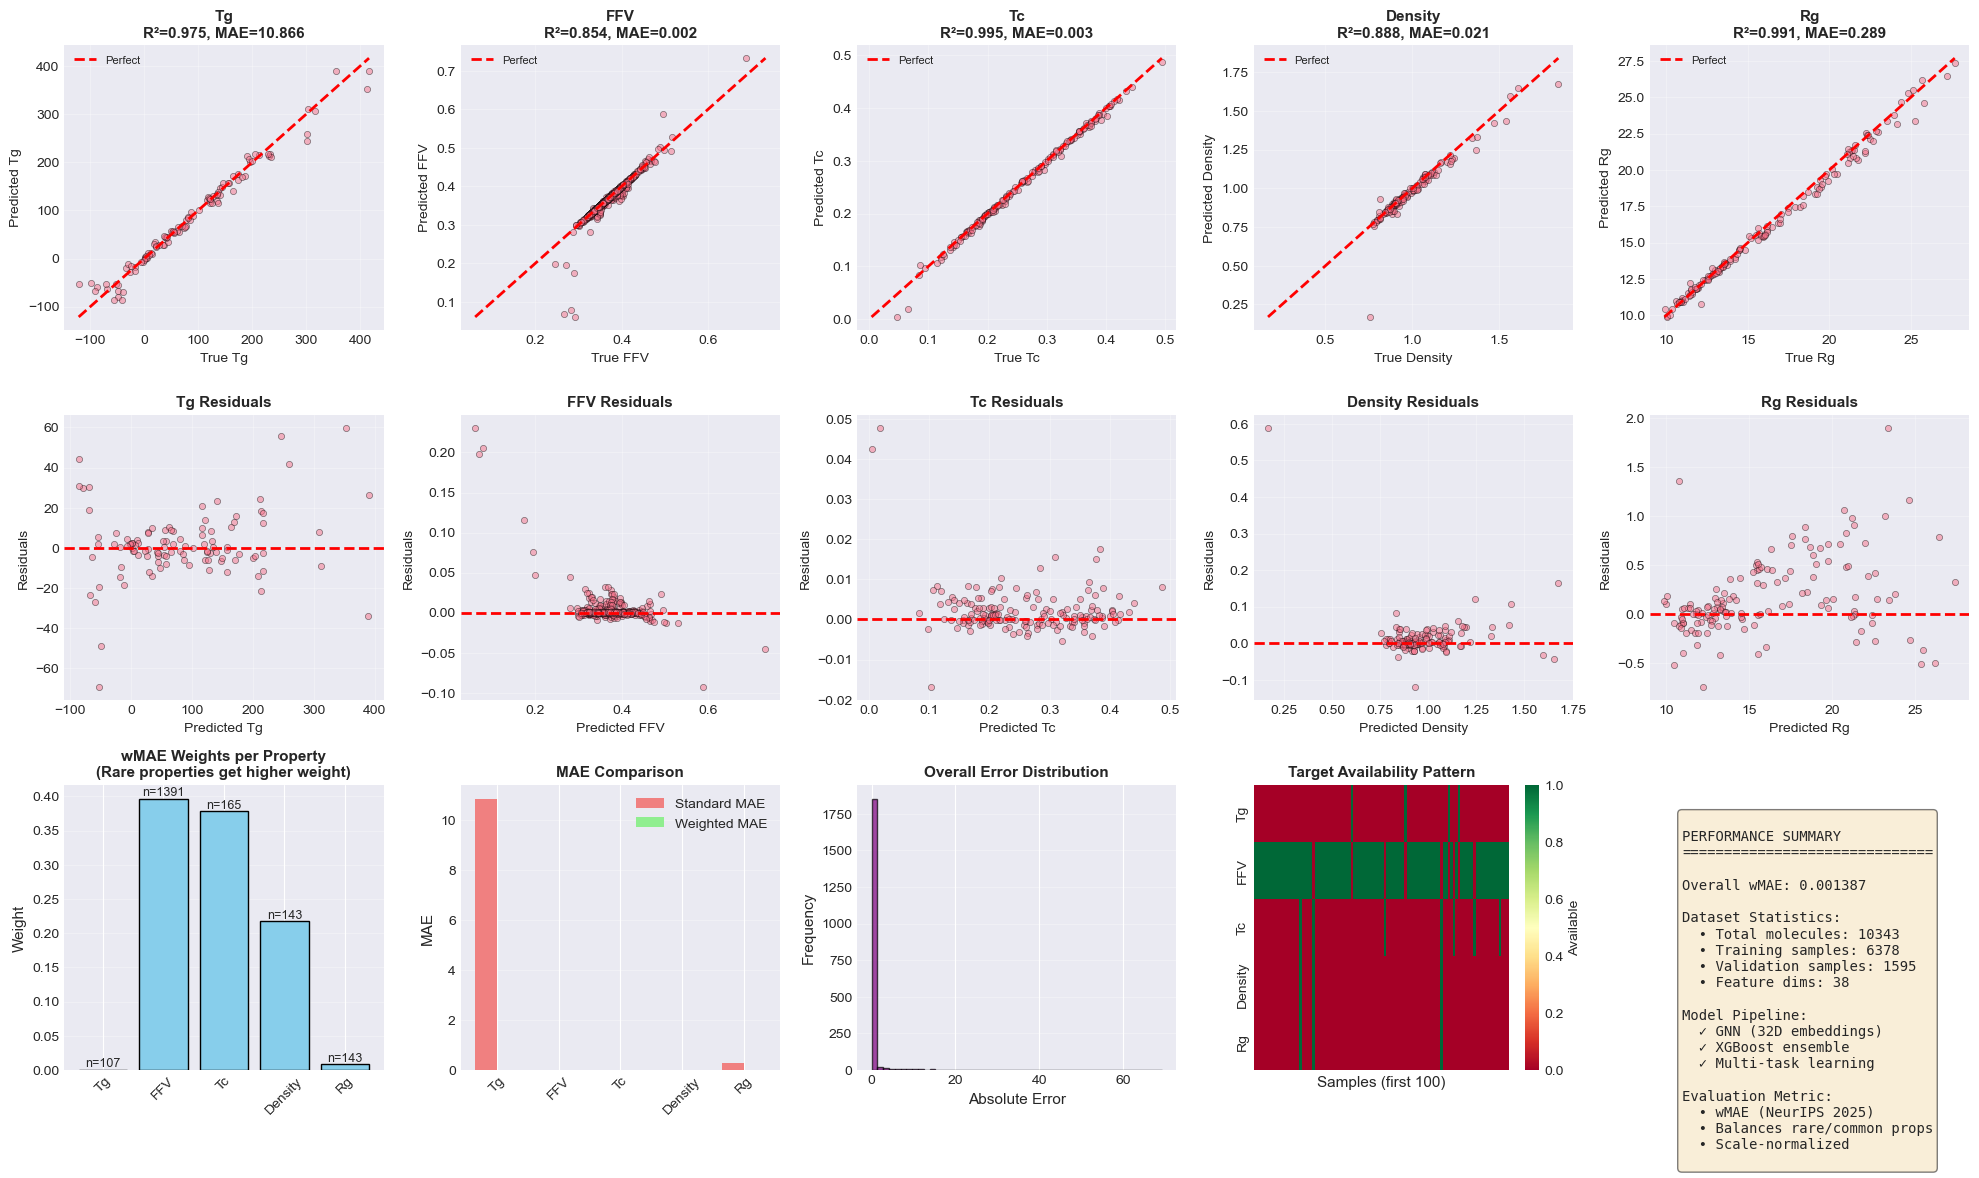


📊 Visualization complete!


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ================================================================
print("\n" + "="*60)
print("📊 CREATING VISUALIZATIONS")
print("="*60)

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# ----------------------------------------------------------------
# 1. Prediction vs True Values (Scatter Plots)
# ----------------------------------------------------------------
print("   Creating scatter plots...")
for i, prop in enumerate(target_columns):
    ax = plt.subplot(3, 5, i + 1)
    
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        
        # Scatter plot
        ax.scatter(y_true, y_pred, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
        
        # Perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
        
        # Compute metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        
        ax.set_xlabel(f'True {prop}', fontsize=10)
        ax.set_ylabel(f'Predicted {prop}', fontsize=10)
        ax.set_title(f'{prop}\nR²={r2:.3f}, MAE={mae:.3f}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

# ----------------------------------------------------------------
# 2. Residual Plots
# ----------------------------------------------------------------
print("   Creating residual plots...")
for i, prop in enumerate(target_columns):
    ax = plt.subplot(3, 5, i + 6)
    
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        residuals = y_true - y_pred
        
        # Residual scatter
        ax.scatter(y_pred, residuals, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
        ax.axhline(y=0, color='r', linestyle='--', lw=2)
        
        ax.set_xlabel(f'Predicted {prop}', fontsize=10)
        ax.set_ylabel('Residuals', fontsize=10)
        ax.set_title(f'{prop} Residuals', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

# ----------------------------------------------------------------
# 3. Weight Visualization
# ----------------------------------------------------------------
print("   Creating weight visualization...")
ax = plt.subplot(3, 5, 11)

weights = [per_property_metrics[prop]['Weight'] for prop in target_columns if prop in per_property_metrics]
frequencies = [per_property_metrics[prop]['Frequency'] for prop in target_columns if prop in per_property_metrics]
props_list = [prop for prop in target_columns if prop in per_property_metrics]

bars = ax.bar(props_list, weights, color='skyblue', edgecolor='black')
ax.set_ylabel('Weight', fontsize=11)
ax.set_title('wMAE Weights per Property\n(Rare properties get higher weight)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

# Add frequency as text on bars
for bar, freq in zip(bars, frequencies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'n={freq}',
            ha='center', va='bottom', fontsize=9)

# ----------------------------------------------------------------
# 4. MAE Comparison (Standard vs Weighted)
# ----------------------------------------------------------------
print("   Creating MAE comparison...")
ax = plt.subplot(3, 5, 12)

mae_standard = [per_property_metrics[prop]['MAE'] for prop in target_columns if prop in per_property_metrics]
mae_weighted = [per_property_metrics[prop]['Weighted_MAE'] for prop in target_columns if prop in per_property_metrics]

x = np.arange(len(props_list))
width = 0.35

bars1 = ax.bar(x - width/2, mae_standard, width, label='Standard MAE', color='lightcoral')
bars2 = ax.bar(x + width/2, mae_weighted, width, label='Weighted MAE', color='lightgreen')

ax.set_ylabel('MAE', fontsize=11)
ax.set_title('MAE Comparison', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(props_list, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# ----------------------------------------------------------------
# 5. Error Distribution
# ----------------------------------------------------------------
print("   Creating error distribution...")
ax = plt.subplot(3, 5, 13)

all_errors = []
for i, prop in enumerate(target_columns):
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        errors = np.abs(y_true - y_pred)
        all_errors.extend(errors)

ax.hist(all_errors, bins=50, edgecolor='black', alpha=0.7, color='purple')
ax.set_xlabel('Absolute Error', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Overall Error Distribution', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# ----------------------------------------------------------------
# 6. Data Availability Heatmap
# ----------------------------------------------------------------
print("   Creating availability heatmap...")
ax = plt.subplot(3, 5, 14)

# Sample availability across properties
availability_matrix = mask_val[:100]  # Show first 100 samples
sns.heatmap(availability_matrix.T, cmap='RdYlGn', cbar_kws={'label': 'Available'},
            yticklabels=target_columns, xticklabels=False, ax=ax)
ax.set_xlabel('Samples (first 100)', fontsize=11)
ax.set_title('Target Availability Pattern', fontsize=11, fontweight='bold')

# ----------------------------------------------------------------
# 7. Performance Summary
# ----------------------------------------------------------------
print("   Creating performance summary...")
ax = plt.subplot(3, 5, 15)
ax.axis('off')

summary_text = f"""
PERFORMANCE SUMMARY
{"="*30}

Overall wMAE: {wmae_score:.6f}

Dataset Statistics:
  • Total molecules: {len(X_combined)}
  • Training samples: {len(X_train)}
  • Validation samples: {len(X_val)}
  • Feature dims: {X_combined.shape[1]}

Model Pipeline:
  ✓ GNN (32D embeddings)
  ✓ XGBoost ensemble
  ✓ Multi-task learning

Evaluation Metric:
  • wMAE (NeurIPS 2025)
  • Balances rare/common props
  • Scale-normalized
"""

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../data/evaluation_results.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved visualization to: ../data/evaluation_results.png")
plt.show()

print("\n📊 Visualization complete!")


📊 DETAILED PER-PROPERTY ANALYSIS
✅ Saved detailed analysis to: ../data/per_property_analysis.png


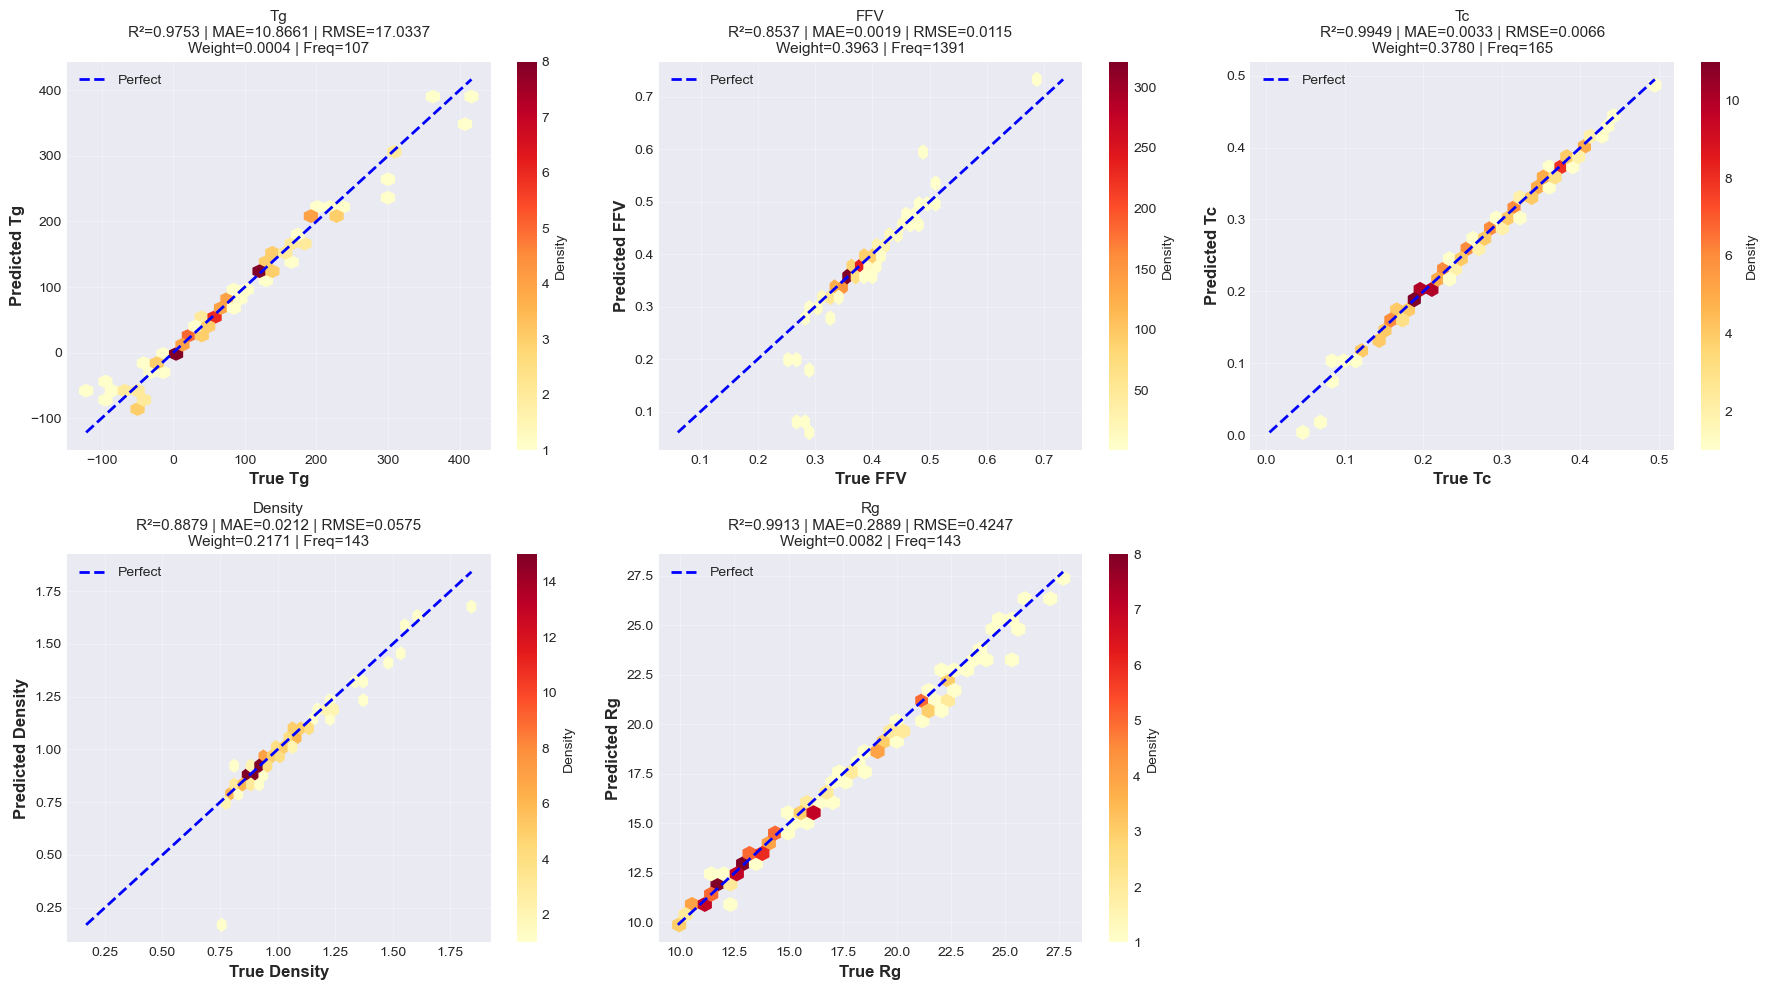

In [15]:
# ================================================================
print("\n" + "="*70)
print("📊 DETAILED PER-PROPERTY ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, prop in enumerate(target_columns):
    ax = axes[i]
    
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        
        # Create hexbin plot for density
        hb = ax.hexbin(y_true, y_pred, gridsize=30, cmap='YlOrRd', mincnt=1)
        
        # Perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'b--', lw=2, label='Perfect')
        
        # Compute detailed metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        # Pearson correlation
        corr, _ = stats.pearsonr(y_true, y_pred)
        
        metrics = per_property_metrics[prop]
        
        ax.set_xlabel(f'True {prop}', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'Predicted {prop}', fontsize=12, fontweight='bold')
        
        title_text = (f"{prop}\n"
                     f"R²={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}\n"
                     f"Weight={metrics['Weight']:.4f} | Freq={metrics['Frequency']}")
        ax.set_title(title_text, fontsize=11)
        
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add colorbar
        plt.colorbar(hb, ax=ax, label='Density')

# Hide extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('../data/per_property_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved detailed analysis to: ../data/per_property_analysis.png")
plt.show()